In [48]:
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse.csgraph import connected_components
from scipy.sparse.linalg import svds
import networkx as nx
from copy import deepcopy
from scipy import linalg
import scipy.stats as stats
import scipy
import matplotlib.pyplot as plt

# Multipartite Graph

The notebook contains the functions used to deal with multipartite graphs - taken from the work we did with microsoft. 

Generally - the functions will take in and out 2 things: 
- the matrix or the embedding
- attributes: two lists, each a dictionary containing information about the rows/columns respectively. 

In [2]:
# replace with own path to data folder:
# path = 'path_to_data_folder'
# path = '/home/ag16115/Documents/phd/codebase_data/brazil'

# finished functions 

## data prep

In [3]:
def graph_from_dataframe(data, partition_pairs, time_col=None, join_token='::'):
    """ 
    Create a DMP graph from a dataframe.    

    Parameters
    ----------
    data : pandas.DataFrame or list of pandas.DataFrame
        The data to be used to create the graph. If a list of dataframes is 
        passed, each dataframe is used to create a separate graph.
    partition_pairs : list of lists
        The partition pairs to be used to create the graph. Each element of
        the list is a list of two elements, which are the names of the
        partitions to be joined.
    time_col : str or list of str
        The name of the column containing the time information. If a list of
        strings is passed, each string is the name of the column containing
        the time information for each dataframe in data.
    join_token : str
        The token used to join the partition name and the node name.

    Returns
    -------
    A : scipy.sparse.csr_matrix
        The adjacency matrix of the graph.  
    attributes : list of lists
        The attributes of the nodes. The first list contains the attributes
        of the nodes that do not change over time. The second list contains
        the attributes of the nodes that change over time.
    """
    # Ensure data and partition_pairs are in list format
    if not isinstance(data, list):
        data = [data]
    if not isinstance(partition_pairs[0][0], list):
        partition_pairs = [partition_pairs]

    # Handle the case when time_col is None
    if time_col is None:
        time_col = [None] * len(data)
    elif isinstance(time_col, str):
        time_col = [time_col] * len(data)

    edge_list = create_edge_list(data, partition_pairs, time_col, join_token)
    nodes, partitions, times, node_ids, time_ids = extract_node_time_info(edge_list, join_token)

    edge_list = transform_edge_data(edge_list, node_ids, time_ids, len(nodes))
    A = create_adjacency_matrix(edge_list, len(nodes), len(times))
    attributes = create_node_attributes(nodes, partitions, times, len(nodes), len(times))

    return A.tocsr(), attributes

def create_edge_list(data, partition_pairs, time_col, join_token):
    edge_list = []
    for data0, partition_pairs0, time_col0 in zip(data, partition_pairs, time_col):
        for partition_pair in partition_pairs0:
            if time_col0:
                pair_data = data0[partition_pair + [time_col0]].drop_duplicates()
                pair_data['T'] = pair_data[time_col0]
                pair_data = pair_data.drop(columns=[time_col0])
            else:
                pair_data = data0[partition_pair].drop_duplicates()
                pair_data['T'] = np.nan
            pair_data.columns = ['V1', 'V2', 'T']
            pair_data['V1'] = [f"{partition_pair[0]}{join_token}{x}" for x in pair_data['V1']]
            pair_data['V2'] = [f"{partition_pair[1]}{join_token}{x}" for x in pair_data['V2']]
            pair_data['P1'] = partition_pair[0]
            pair_data['P2'] = partition_pair[1]
            edge_list.append(pair_data)
            print(partition_pair)
    return pd.concat(edge_list)

def extract_node_time_info(edge_list, join_token):
    nodes = sorted(set(edge_list['V1']).union(edge_list['V2']))
    partitions = [node.split(join_token)[0] for node in nodes]
    times = sorted(set(edge_list['T'].unique()))
    # times = sorted(set(edge_list['T']))
    node_ids = {node: idx for idx, node in enumerate(nodes)}
    time_ids = {time: idx for idx, time in enumerate(times)}
    return nodes, partitions, times, node_ids, time_ids

def transform_edge_data(edge_list, node_ids, time_ids, n_nodes):
    edge_list['V_ID1'] = edge_list['V1'].map(node_ids)
    edge_list['V_ID2'] = edge_list['V2'].map(node_ids)
    edge_list['T_ID'] = edge_list['T'].map(time_ids)
    edge_list['X_ID1'] = edge_list['T_ID'] * n_nodes + edge_list['V_ID1']
    edge_list['X_ID2'] = edge_list['T_ID'] * n_nodes + edge_list['V_ID2']
    return edge_list

def create_adjacency_matrix(edge_list, n_nodes, n_times):
    row_indices = pd.concat([edge_list['V_ID1'], edge_list['V_ID2']])
    col_indices = pd.concat([edge_list['X_ID2'], edge_list['X_ID1']])
    values = np.ones(2 * len(edge_list))
    return sparse.coo_matrix((values, (row_indices, col_indices)), shape=(n_nodes, n_nodes * n_times))

def create_node_attributes(nodes, partitions, times, n_nodes, n_times):
    time_attrs = np.repeat(times, n_nodes)
    attributes = [
        [{'name': name, 'partition': partition, 'time': np.nan} for name, partition in zip(nodes, partitions)],
        [{'name': name, 'partition': partition, 'time': time} for name, partition, time in zip(nodes * n_times, partitions * n_times, time_attrs)]
    ]
    return attributes

In [4]:
# realise this may seem like a convoluted way to do this but it'll make it easier to add time element later
def find_subgraph(A, attributes, subgraph_attributes):
    """
    Find a subgraph of a multipartite graph.

    Parameters
    ----------
    A : scipy.sparse.csr_matrix
        The adjacency matrix of the multipartite graph.
    attributes : list of lists
        The attributes of the nodes. The first list contains the attributes
        of the nodes in rows. The second list contains
        the attributes of the nodes in the columns.
    subgraph_attributes : list of lists
        The attributes of the nodes of the wanted in the subgraph. The first list contains
        the attributes of the nodes wanted in the rows. The second
        list contains the attributes of the nodes wanted in the column.

    Returns
    -------
    subgraph_A : scipy.sparse.csr_matrix
        The adjacency matrix of the subgraph.
    subgraph_attributes : list of lists
        The attributes of the nodes of the subgraph. The first list contains
        the attributes of the nodes in the rows. The second
        list contains the attributes of the nodes in the columns.
    """

    if not isinstance(subgraph_attributes[0], list):
        subgraph_attributes[0] = [subgraph_attributes[0]]

    if not isinstance(subgraph_attributes[1], list):
        subgraph_attributes[1] = [subgraph_attributes[1]]

    # find the indices of the rows with required attributes
    subgraph_node_indices_row = []
    for node_idx, node_attributes in enumerate(attributes[0]):
        for each_subgraph_attributes in subgraph_attributes[0]:
            matched = True
            for key, value in each_subgraph_attributes.items():
                if key not in node_attributes or node_attributes[key] != value:
                    matched = False
                    break
            if matched:
                subgraph_node_indices_row.append(node_idx)

    # find the indices of the columns with required attributes
    subgraph_node_indices_col = []
    for node_idx, node_attributes in enumerate(attributes[1]):
        for each_subgraph_attributes in subgraph_attributes[1]:
            matched = True
            for key, value in each_subgraph_attributes.items():
                if key not in node_attributes or node_attributes[key] != value:
                    matched = False
                    break
            if matched:
                subgraph_node_indices_col.append(node_idx)

    # create subgraph and subgraph attributes
    subgraph_A = A[np.ix_(subgraph_node_indices_row,
                          subgraph_node_indices_col)]
    subgraph_attributes = [[attributes[0][i] for i in subgraph_node_indices_row], [
        attributes[1][i] for i in subgraph_node_indices_col]]

    return subgraph_A, subgraph_attributes

In [5]:
def zero_matrix(m, n = None):
    """
    Create a zero matrix.
    """
    if n == None:
        n = m
    M = sparse.coo_matrix(([],([],[])),shape = (m,n))
    return M

def symmetric_dilation(M):
    """
    Dilate a matrix to a symmetric matrix.
    """
    m, n = M.shape
    D = sparse.vstack([sparse.hstack([zero_matrix(m), M]), sparse.hstack([M.T, zero_matrix(n)])])
    return D

def subgraph_idx(A, attributes, idx0, idx1):
    """
    Find a subgraph of a multipartite graph by indices.
    """  
    subgraph_A = A[np.ix_(idx0, idx1)]
    subgraph_attributes = [
        [attributes[0][i] for i in idx0],
        [attributes[1][i] for i in idx1]
    ]
    return subgraph_A, subgraph_attributes

## check what happens when repeated partition in row and column
def find_connected_components(A, attributes, n_components = 1):
    """
    Find connected components of a multipartite graph.

    Parameters
    ----------
    A : scipy.sparse.csr_matrix
        The adjacency matrix of the graph.
    attributes : list of lists
        The attributes of the nodes. The first list contains the attributes
        of the nodes in rows. The second list contains
        the attributes of the nodes in the columns.
    n_components : int
        The number of components to be found.

    Returns
    -------
    cc_As : list of scipy.sparse.csr_matrix
        The adjacency matrices of the connected components.
    cc_attributes : list of lists
        The attributes of the nodes of the connected components. The first list contains
        the attributes of the nodes in the rows. The second
        list contains the attributes of the nodes in the columns.
    """
    
    A_dilation = symmetric_dilation(A)
    _, cc = connected_components(A_dilation)
    cc = [cc[:A.shape[0]], cc[A.shape[0]:]]
    if n_components == None:
        n_components = np.max(cc) + 1
    else:
        cc_As = []
        cc_attributes = []
        for i in range(n_components):
            idx0 = np.where(cc[0] == i)[0]
            idx1 = np.where(cc[1] == i)[0]
            store_cc_A, store_cc_attributes = subgraph_idx(A,attributes, idx0, idx1)
            cc_As.append(store_cc_A)
            cc_attributes.append(store_cc_attributes)
        if len(cc_As) == 1:
            cc_As = cc_As[0]
            cc_attributes = cc_attributes[0]
        return cc_As, cc_attributes


In [6]:
def to_networkx(A, attributes, symmetric=None):
    """ 
    Convert a multipartite graph to a networkx graph.
    """
    if symmetric == None:
        if is_symmetric(A):
            symmetric = True
        else:
            symmetric = False
    if symmetric:
        G_nx = nx.Graph(A)
        nx.set_node_attributes(G_nx, {i: a for i, a in enumerate(attributes[0])})
        return G_nx
    else:
        n0 = len(attributes[0])
        n1 = len(attributes[1])
        G_nx = nx.Graph(symmetric_dilation(A))
        nx.set_node_attributes(G_nx, {i: a for i, a in enumerate(attributes[0])})
        nx.set_node_attributes(G_nx, {i + n0: a for i, a in enumerate(attributes[1])})
        nx.set_node_attributes(G_nx, {i: {'bipartite': 0} for i in range(n0)})
        nx.set_node_attributes(G_nx, {i + n0: {'bipartite': 1} for i in range(n1)})
        return G_nx

## embedding

In [49]:
def dim_select(A, plot=True, plotrange=50):
    ## NEEDS UPDATING FOR DILATED MATRIX ##
    """ 
    Select the number of dimensions for A.
    Finding a changepoint using the likelihood profile (Zhu, Ghodsi; 2006).

    Parameters
    ----------  
    As : numpy.array
        The array of matrices.
    plot : bool
        Whether to plot the singular values and the likelihood profile.
    plotrange : int
        The range of dimensions to be plotted.

    Returns
    -------
    lq_best : int
        The number of dimensions selected.
    """   
    if scipy.sparse.issparse(A):
        A = A.todense()

    # # Construct rectangular matrices
    # if len(As.shape) == 2:
    #     As = np.array([As[:,:]])
    
    # if len(As.shape) == 3:
    #     T = len(As)
    #     A = As[0,:,:]
    #     for t in range(1,T):
    #         A = np.block([A,As[t]])
            
    UA, SA, VAt = np.linalg.svd(A)
    
    # Compute likelihood profile
    n = len(SA)
    lq = np.zeros(n); lq[0] = 'nan'
    for q in range(1,n):
        theta_0 = np.mean(SA[:q])
        theta_1 = np.mean(SA[q:])
        sigma = np.sqrt(((q-1)*np.var(SA[:q]) + (n-q-1)*np.var(SA[q:])) / (n-2))
        lq_0 = np.sum(np.log(stats.norm.pdf(SA[:q], theta_0, sigma)))
        lq_1 = np.sum(np.log(stats.norm.pdf(SA[q:], theta_1, sigma)))
        lq[q] = lq_0 +lq_1    
    lq_best = np.nanargmax(lq)

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(12.0,4.0))
        plt.subplots_adjust(hspace = 0.3)
        
        axs[0].plot(range(plotrange), SA[:plotrange], '.-')
        axs[0].set_title('Singular values')
        axs[0].set_xlabel('Number of dimensions')
        axs[0].axvline(x=lq_best, ls='--', c='k')

        axs[1].plot(range(plotrange), lq[:plotrange], '.-')
        axs[1].set_title('Log likelihood')
        axs[1].set_xlabel('Number of dimensions')
        axs[1].axvline(x=lq_best, ls='--', c='k');
        
    return lq_best

In [7]:
def safe_inv_sqrt(a, tol=1e-12):
    """
    Compute the inverse square root of an array, ignoring division by zero.
    """
    with np.errstate(divide="ignore"):
        b = 1 / np.sqrt(a)
    b[np.isinf(b)] = 0
    b[a < tol] = 0
    return b

def to_laplacian(A, regulariser=0):
    """
    Convert an adjacency matrix to a Laplacian matrix.

    Parameters
    ----------
    A : scipy.sparse.csr_matrix
        The adjacency matrix.
    regulariser : float
        The regulariser to be added to the degrees of the nodes.

    Returns
    -------
    L : scipy.sparse.csr_matrix
        The Laplacian matrix.
    """

    left_degrees = np.reshape(np.asarray(A.sum(axis=1)), (-1,))
    right_degrees = np.reshape(np.asarray(A.sum(axis=0)), (-1,))
    if regulariser == 'auto':
        regulariser = np.mean(np.concatenate((left_degrees, right_degrees)))
    left_degrees_inv_sqrt = safe_inv_sqrt(left_degrees + regulariser)
    right_degrees_inv_sqrt = safe_inv_sqrt(right_degrees + regulariser)
    L = sparse.diags(left_degrees_inv_sqrt) @ A @ sparse.diags(right_degrees_inv_sqrt)
    return L

def embed(A, d = 10, matrix = 'adjacency', regulariser = 0):
    """ 
    Embed a graph using the laplacian or adjacency matrix.  

    Parameters  
    ----------  
    A : scipy.sparse.csr_matrix  
        The adjacency matrix of the graph.  
    d : int 
        The dimension of the embedding.
    matrix : str    
        The matrix to be used for embedding.
    regulariser : float 
        The regulariser to be added to the degrees of the nodes (if matrix = 'laplacian' used).    

    Returns 
    ------- 
    left_embedding : numpy.ndarray 
        The left embedding of the graph.    
    right_embedding : numpy.ndarray 
        The right embedding of the graph.    
    """

    if matrix == 'laplacian':
        L = to_laplacian(A, regulariser)
        u, s, vT = svds(L, d)
    else:
        u, s, vT = svds(A, d)
    o = np.argsort(s[::-1])
    left_embedding = u[:,o] @ np.diag(np.sqrt(s[o]))
    right_embedding = vT.T[:,o] @ np.diag(np.sqrt(s[o]))                      
    return left_embedding, right_embedding

## post embedding functions

In [8]:
def is_symmetric(m):
    """Check if a sparse matrix is symmetric

    Parameters
    ----------
    m : array or sparse matrix

    Returns
    -------
    check : bool
        The check result.

    """
    if m.shape[0] != m.shape[1]:
        return False

    if not isinstance(m, sparse.coo_matrix):
        m = sparse.coo_matrix(m)

    r, c, v = m.row, m.col, m.data
    tril_no_diag = r > c
    triu_no_diag = c > r

    if triu_no_diag.sum() != tril_no_diag.sum():
        return False

    rl = r[tril_no_diag]
    cl = c[tril_no_diag]
    vl = v[tril_no_diag]
    ru = r[triu_no_diag]
    cu = c[triu_no_diag]
    vu = v[triu_no_diag]

    sortl = np.lexsort((cl, rl))
    sortu = np.lexsort((ru, cu))
    vl = vl[sortl]
    vu = vu[sortu]

    check = np.allclose(vl, vu)

    return check

In [9]:
def recover_subspaces(embedding, attributes):
    """
    Recover the subspaces for each partition from an embedding.

    Parameters
    ----------
    embedding : numpy.ndarray
        The embedding of the graph.
    attributes : list of lists
        The attributes of the nodes. The first list contains the attributes
        of the nodes in rows. The second list contains
        the attributes of the nodes in the columns.

    Returns
    -------
    partition_embeddings : dict
        The embeddings of the partitions.
    partition_attributes : dict
        The attributes of the nodes in the partitions.
    """

    partitions = list(set([x['partition'] for x in attributes]))
    partition_embeddings = {}
    partition_attributes = {}
    for p in partitions:
        p_embedding, p_attributes = select(embedding,attributes, {'partition': p})
        Y = p_embedding
        u, s, vT = linalg.svd(Y, full_matrices=False)
        o = np.argsort(s[::-1])
        Y = Y @ vT.T[:, o]
        partition_embeddings[p] = Y
        partition_attributes[p] = p_attributes
    return partition_embeddings, partition_attributes

def select(embedding, attributes, select_attributes):
    """
    Select portion of embedding and attributes associated with a set of attributes.
    """
    if not isinstance(select_attributes, list):
        select_attributes = [select_attributes]
    which_nodes = list()
    for attributes_dict in select_attributes:
        for a, v in attributes_dict.items():
            if not isinstance(v, list):
                v = [v]
        which_nodes_by_attribute = [[i for i, y in enumerate(attributes) if y[a] in v] for a, v in attributes_dict.items()]
        which_nodes.append(list(set.intersection(*map(set, which_nodes_by_attribute))))
    which_nodes = list(set().union(*which_nodes))
    selected_X = embedding[which_nodes, :]
    selected_attributes = [attributes[i] for i in which_nodes]
    return selected_X, selected_attributes

In [10]:
def truncate(X, d):
    """
    Truncate an embedding to a lower dimension.
    """
    Y = X[:, :d]
    return Y

In [11]:
def degree_correction(X):
    """
    Perform degree correction.
    """
    tol = 1e-12
    Y = deepcopy(X)
    norms = np.linalg.norm(X, axis=1)
    idx = np.where(norms > tol)
    Y[idx] = X[idx] / (norms[idx, None])
    return Y

# data types

## dynamic - lyon school 

In [32]:
# load data 
# need the activity_data.csv file
path = '/home/ag16115/Documents/phd/codebase_data/'
data = pd.read_csv(path + 'ia-primary-school-proximity-attr.edges', sep = ',', on_bad_lines='skip', header = None)
# data = pd.read_csv(path + '/activity_data.csv', sep = '\t', on_bad_lines='skip')

In [33]:
## rename columns   
data.columns = ['V1', 'V2', 'T', 'L1', 'L2']
## sort out time column
data['H'] = [int(int(t)/(60*60)) for t in list(data['T'])]
data['D'] = [int(int(t)/(60*60*24)) for t in list(data['T'])]
data['T1'] = [10*int(i/24) + i%24 - 8 for i in list(data['H'])]

In [63]:
## find the intersection of two lists   
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [66]:
## find the union of two lists  
def union(lst1, lst2): 
    final_list = list(set(lst1) | set(lst2)) 
    return final_list

In [67]:
len(union(data['V1'],data['V2']))

242

In [ ]:
## problem: graph_from_dataframe cannot take in two columns which contain the same partition

In [62]:
data

,V1,V2,T,L1,L2,H,D,T1
0,1558,1567,31220,3B,3B,8,0,0
1,1560,1570,31220,3B,3B,8,0,0
2,1567,1574,31220,3B,3B,8,0,0
3,1632,1818,31220,4B,4B,8,0,0
4,1632,1866,31220,4B,4B,8,0,0
...,...,...,...,...,...,...,...,...
125768,1752,1783,148120,1A,1A,41,1,19
125769,1752,1789,148120,1A,1A,41,1,19
125770,1775,1798,148120,1A,1A,41,1,19
125771,1783,1796,148120,1A,1A,41,1,19


In [34]:
# making A matrix and attributes
A, attributes = graph_from_dataframe(data, [['V1', 'V2']], time_col = 'T1', join_token='::')

['V1', 'V2']


In [68]:
attributes[0]

[{'name': 'V1::1426', 'partition': 'V1', 'time': nan},
 {'name': 'V1::1427', 'partition': 'V1', 'time': nan},
 {'name': 'V1::1428', 'partition': 'V1', 'time': nan},
 {'name': 'V1::1429', 'partition': 'V1', 'time': nan},
 {'name': 'V1::1430', 'partition': 'V1', 'time': nan},
 {'name': 'V1::1431', 'partition': 'V1', 'time': nan},
 {'name': 'V1::1434', 'partition': 'V1', 'time': nan},
 {'name': 'V1::1435', 'partition': 'V1', 'time': nan},
 {'name': 'V1::1437', 'partition': 'V1', 'time': nan},
 {'name': 'V1::1439', 'partition': 'V1', 'time': nan},
 {'name': 'V1::1441', 'partition': 'V1', 'time': nan},
 {'name': 'V1::1443', 'partition': 'V1', 'time': nan},
 {'name': 'V1::1451', 'partition': 'V1', 'time': nan},
 {'name': 'V1::1452', 'partition': 'V1', 'time': nan},
 {'name': 'V1::1453', 'partition': 'V1', 'time': nan},
 {'name': 'V1::1457', 'partition': 'V1', 'time': nan},
 {'name': 'V1::1458', 'partition': 'V1', 'time': nan},
 {'name': 'V1::1459', 'partition': 'V1', 'time': nan},
 {'name': 

In [52]:
len(attributes[0])

480

In [59]:
UA, SA, VAt = scipy.sparse.linalg.svds(A,k=50)

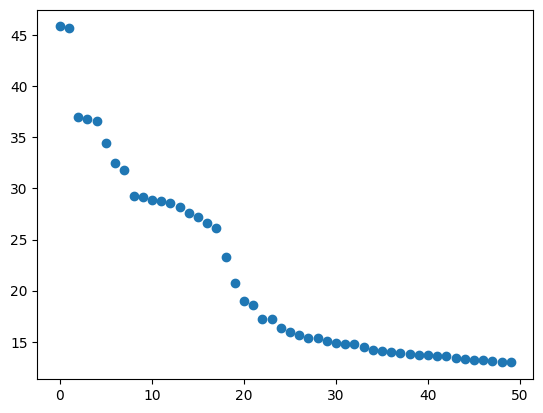

In [61]:
## create scatter plot of SA    
plt.scatter(range(50), SA[::-1])

In [57]:
SA

array([34.43745863, 36.63313237, 36.74089574, 37.00044636, 45.66293343,
       45.83614108])

In [ ]:
def scree_plot(A, s = 1, vline=None):

In [ ]:
dim_select(A)

In [ ]:
    if matrix == 'laplacian':
        L = to_laplacian(A, regulariser)
        u, s, vT = svds(L, d)
    else:
        u, s, vT = svds(A, d)
    o = np.argsort(s[::-1])
    left_embedding = u[:,o] @ np.diag(np.sqrt(s[o]))
    right_embedding = vT.T[:,o] @ np.diag(np.sqrt(s[o]))                      

In [ ]:
def scree_plot(embedding, range = 50, plot = True, s = 1, vline=None):
    fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
    plt.scatter(range(len(embedding.metadata['singular values'])), np.sort(embedding.metadata['singular values'])[::-1], s =s)
    if vline:
        plt.axvline(x=vline, color='green', linewidth=0.5)
        
def subspace_scree_plots(embeddings, s = 1, vlines=None):
    fig, axs = plt.subplots(len(embeddings), figsize=(12,4*len(embeddings)))
    fig.patch.set_facecolor('white')
    for i, p in enumerate(embeddings.keys()):
        axs[i].title.set_text(p)
        axs[i].scatter(range(len(embeddings[p].metadata['partition singular values'])), np.sort(embeddings[p].metadata['partition singular values'])[::-1], s =s)
        if vlines:
            axs[i].axvline(x=vlines[i], color='green', linewidth=0.5)

In [36]:
A

<480x9600 sparse matrix of type '<class 'numpy.float64'>'
	with 52702 stored elements in Compressed Sparse Row format>

In [35]:
attributes

[[{'name': 'V1::1426', 'partition': 'V1', 'time': nan},
  {'name': 'V1::1427', 'partition': 'V1', 'time': nan},
  {'name': 'V1::1428', 'partition': 'V1', 'time': nan},
  {'name': 'V1::1429', 'partition': 'V1', 'time': nan},
  {'name': 'V1::1430', 'partition': 'V1', 'time': nan},
  {'name': 'V1::1431', 'partition': 'V1', 'time': nan},
  {'name': 'V1::1434', 'partition': 'V1', 'time': nan},
  {'name': 'V1::1435', 'partition': 'V1', 'time': nan},
  {'name': 'V1::1437', 'partition': 'V1', 'time': nan},
  {'name': 'V1::1439', 'partition': 'V1', 'time': nan},
  {'name': 'V1::1441', 'partition': 'V1', 'time': nan},
  {'name': 'V1::1443', 'partition': 'V1', 'time': nan},
  {'name': 'V1::1451', 'partition': 'V1', 'time': nan},
  {'name': 'V1::1452', 'partition': 'V1', 'time': nan},
  {'name': 'V1::1453', 'partition': 'V1', 'time': nan},
  {'name': 'V1::1457', 'partition': 'V1', 'time': nan},
  {'name': 'V1::1458', 'partition': 'V1', 'time': nan},
  {'name': 'V1::1459', 'partition': 'V1', 'time'

## multipartite - brazil

The data contains information about the procurement process in Brazil. Each row contains information about a tender with information:
- Tender: tender id
- Period: time 
- Buyer: who is funding
- Item: what the tender is abour 
- Company: who has bid for the tender
- bidder_win: whether the bid was won or not

In [21]:
data = pd.read_csv(path + 'brazil/activity_data.csv', sep = '\t', on_bad_lines='skip')
A, attributes = graph_from_dataframe(data, [['Company', 'Tender'],['Company', 'Buyer'],['Company', 'Item']], join_token='::')

/tmp/ipykernel_40608/771886302.py:1: DtypeWarning: Columns (13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path + 'brazil/activity_data.csv', sep = '\t', on_bad_lines='skip')


['Company', 'Tender']
['Company', 'Buyer']
['Company', 'Item']


In [ ]:
# find subgraph wanted

subgraph_attributes = [
    [{'partition': 'Company'},{'partition': 'Tender'}],
    {'partition': 'Buyer'}
]

# subgraph_attributes = [
#     {'partition': 'Company'},
#     {'partition': 'Buyer'}
# ]
subgraph_A, subgraph_attributes  = find_subgraph(A, attributes,subgraph_attributes)

In [ ]:
# A_dilation = symmetric_dilation(subgraph_A)
# is_symmetric(A_dilation)

In [ ]:
# take the largest connected component
cc_A, cc_attributes = find_connected_components(subgraph_A, subgraph_attributes,n_components = 1)

In [ ]:
# G = to_networkx(cc_A, cc_attributes)
# G.number_of_nodes()
# G.nodes[1]
# list(G.nodes)

In [ ]:
# get left and right embeddings
left_embed, right_embed = embed(cc_A, matrix = 'laplacian')
# the attributes associated with left_embed and right_embed are cc_attributes[0] and cc_attributes[1]
left_attributes = cc_attributes[0]
right_attributes = cc_attributes[1]

In [ ]:
partition_embeddings, partition_attributes = recover_subspaces(left_embed,left_attributes)

In [ ]:
partition_embeddings['Company'] = degree_correction(partition_embeddings['Company'])